# G02 - Traffic sign detection and classification

# Imports

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

import os

import openpyxl
import math

from os import listdir
from os.path import isfile, join

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score
import seaborn as sb



dataDir = './archive/imagesClean'
improvementsImagesDir = './archive/imagesForImprovements'
anotation_path = './archive/annotations'

# Run to generate the initial file 
## Filtered dataset information processed - basic version 85% of the grade

In [2]:
# import xlsxwriter module
import xlsxwriter
import xml.dom.minidom


from os import listdir, remove
from os.path import isfile, join
onlyfiles = [".".join(f.split(".")[:-1]) for f in listdir(dataDir) if isfile(join(dataDir, f))]
 
workbook = xlsxwriter.Workbook('RoadSigns.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'File Name')
worksheet.write('B1', 'Type of Sign')
worksheet.write('C1', 'Type of Sign Detected')
# Start from the first cell.
# Rows and columns are zero indexed.
row = 1
column = 0

 
# iterating through content list
for item in onlyfiles :
    typeOfSign = "";
    doc = xml.dom.minidom.parse(os.path.join(anotation_path,item + ".xml"));
    
    signsNames = doc.getElementsByTagName("name")
    
#     # If more than one annotation, erase image (Code used to reduce the dataset)
#     if len(signsNames) > 1 or signsNames[0].childNodes[0].nodeValue == "trafficlight":
#         os.remove('./archive/imagesClean/' + item + '.png')   
#         continue
        

    for sign in signsNames:
        if sign.childNodes[0].nodeValue == "crosswalk":
            typeOfSign = "crosswalk";
        elif sign.childNodes[0].nodeValue == "stop":
            typeOfSign = "stop";
        elif sign.childNodes[0].nodeValue == "speedlimit":
            typeOfSign = "speedlimit";
    
    # write operation perform
    if typeOfSign == "speedlimit" or typeOfSign == "stop" or typeOfSign == "crosswalk":
        worksheet.write(row, column, item)
        worksheet.write(row, 1, typeOfSign) 
    else:
        worksheet.write(row, column, item)
        worksheet.write(row, 1, "other")
     
    # incrementing the value of row by one
    # with each iterations.
    row += 1
     
workbook.close()

# Functions to Detect Red Circles

In [3]:
# CLAHE

def clahe(testImg):
    testImg = cv2.cvtColor(testImg, cv2.COLOR_RGB2HSV)

    # Getting the brightness channel only, since we are using colored images
    h, s, v = testImg[:,:,0], testImg[:,:,1], testImg[:,:,2]

    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))

    # Applying equalization to the brightness channel
    v = clahe.apply(v)

    testImg = np.dstack((h, s, v))

    testImg = cv2.cvtColor(testImg, cv2.COLOR_HSV2RGB)
    
    return testImg

# REMOVE SHADOWS

# Normalizing each channel
# Solution found on https://stackoverflow.com/questions/44752240/how-to-remove-shadow-from-scanned-images-using-opencv
def removeShadows(testImg):
    
    rgb_planes = cv2.split(testImg)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)

    testImg = cv2.merge(result_norm_planes)
    
    return testImg

#

# Applying a red mask to retrieve only red sections
def redMask(testImg):
    
    testImgRed = testImg.copy()
    testImg = cv2.cvtColor(testImg, cv2.COLOR_RGB2HSV)

    # lower mask (0-10)
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(testImg, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(testImg, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1

    
    testImgRed = cv2.cvtColor(testImgRed, cv2.COLOR_RGB2HSV)
    
    testImgRed[np.where(mask==0)] = 0
    
    testImgRed = cv2.cvtColor(testImgRed, cv2.COLOR_HSV2RGB)
    
    testImg = cv2.cvtColor(testImg, cv2.COLOR_HSV2RGB)
    
    return testImgRed


# Applying a blue mask to retrieve blue sections only
def blueMaskCircle(testImg):
    
    testImgBlue = testImg.copy()
    testImg = cv2.cvtColor(testImg, cv2.COLOR_RGB2HSV)

    # lower mask (0-10)
    lower_blue= np.array([100, 150, 0])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(testImg, lower_blue, upper_blue)
    
    testImgBlue = cv2.cvtColor(testImgBlue, cv2.COLOR_RGB2HSV)
    
    testImgBlue[np.where(mask==0)] = 0
    
    testImgBlue = cv2.cvtColor(testImgBlue, cv2.COLOR_HSV2RGB)
    
    testImg = cv2.cvtColor(testImg, cv2.COLOR_HSV2RGB)
    
    return testImgBlue

# CLOSING to close gaps in the circles

def closing(testImgRed):
    # Blurr to prevent artifacts like branches from being detected
    testImgRed = cv2.GaussianBlur(testImgRed, (11,11), 3)
    testImgGray = cv2.cvtColor(testImgRed, cv2.COLOR_RGB2GRAY)
    # Using a circular structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    testImgGray = cv2.morphologyEx(testImgGray, cv2.MORPH_CLOSE, kernel)

    return testImgGray


# Find the circles in an image
def findCircles(testImgRed):
    # Use the Hough transform to detect circles in the image
    circles = cv2.HoughCircles(testImgRed, cv2.HOUGH_GRADIENT, 1, testImgRed.shape[0] / 8, param1=50, param2=45, minRadius=0, maxRadius=0)
    # If we have extracted a circle, draw an outline
    # We only need to detect one circle here, since there will only be one reference object
    return circles

# Main circle detection function (receives the image to detect the circles on,
# if it should draw the circles in an image, the image to draw the circles on, and 
# the color of the circles it should detect - red or blue)
def detectCircles(ogImage, draw, imgToDraw, color):
    ogImage = cv2.cvtColor(ogImage, cv2.COLOR_BGR2RGB)
    finalImg = ogImage.copy()
    testImg = ogImage.copy()
    
    # Define which mask to use (red or blue) depending on the received color parameter
    label = "Red Circle"
    if (color == "red"):
        mask = redMask
    else:
        mask = blueMaskCircle
        label = "Blue Circle"
        
    # Try different approaches to try and find circles
    for i in range(3):
        testImg = ogImage.copy()
        # Removes shadows first
        if i == 0:
            noShadows = removeShadows(testImg)
            colorOnly = mask(noShadows)
            grayClosing = closing(colorOnly)
            circles = findCircles(grayClosing)        
        # Applies CLAHE first
        if i == 1:
            claheImg = clahe(testImg)
            colorOnly = mask(claheImg)
            grayClosing = closing(colorOnly)
            circles = findCircles(grayClosing)
        # Tries to simply detect the circle through the mask
        if i == 2:
            colorOnly = mask(testImg)
            grayClosing = closing(colorOnly)
            circles = findCircles(grayClosing)
        if circles is not None:
            if draw:
                circles = np.uint16(np.around(circles))
                for i in circles[0,:]:
                    # draw the outer circle
                    cv2.circle(imgToDraw,(i[0],i[1]),i[2],(39, 255, 0),2)
                    # draw the center of the circle
                    cv2.circle(imgToDraw,(i[0],i[1]),2,(0,0,255),3)
                    # write text
                    cv2.putText(img=imgToDraw, text=label, org=(i[0]-45,i[1]+i[2]+15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(39, 255, 0),thickness=2)
                finalImg = cv2.cvtColor(finalImg, cv2.COLOR_RGB2BGR)
                
            return (circles.shape[1],imgToDraw)
    return (0, ogImg.copy())
    
    


# Function to Detect Red Circles - Example

In [4]:
ogImg = cv2.imread(os.path.join(dataDir, "road119.png"))   
    
(nrCircles, ogImg) = detectCircles(ogImg, True, ogImg, "red")

cv2.imshow('Red Circles Detected', ogImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Functions for Squared/Rectangle and Stop Detection

In [5]:
# Used to evaluate the distance between coners detected and prune out 
# results in which corners are too closely together to be considered a traffic sign

def differenceBtwPointsTooSmall(array,size):
    maxLimit = size-1
    pointsDistanceSum = 0
    for i in range(size):
        if i != maxLimit:
            pointsDistanceSum += math.dist(array[i][0],array[i+1][0])
        else:
            pointsDistanceSum += math.dist(array[i][0],array[0][0])
    
    averageValue = pointsDistanceSum / size   
    if size < 8:
        if averageValue <= 12.5:
            return True
    else:
        if averageValue <= 8:
            return True
    
    return False

# Function to Detect Blue Squares/Rectangles

In [6]:
# Applies blue mask to image in order to acquire blue sections of the image
def blueMask(testImg):
    
    hsv = cv2.cvtColor(testImg,cv2.COLOR_BGR2HSV)

    originalImage = testImg.copy()
    
    # Dark blues (the most common for traffic signs)
    lower_blue= np.array([100,150,0])
    upper_blue = np.array([140,255,255])

    mask2 = cv2.inRange(hsv, lower_blue, upper_blue)
    res = cv2.bitwise_and(originalImage,originalImage, mask= mask2)

    return res
# Applies dilation transformation to image in order to close possible "open sides" 
def dilateSquare(image):
    
    # Best kernel size for this project (different values tried out)
    kernel = np.ones((9,9), np.uint8)
    image = cv2.dilate(image, kernel)
    
    return image

# Uses altered images and approxPolyDP to identify squares in processed images
def findBlueSquaredRectangles(image,dilate,erode):
    ret,thresh1 = cv2.threshold(image[:,:,0], 0, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh1 = cv2.bitwise_not(thresh1)
    
    if dilate:
        thresh1 = dilateSquare(thresh1)
        
    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    signs = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt,0.0125*cv2.arcLength(cnt,True),True)
        if len(approx)==4 and not differenceBtwPointsTooSmall(approx,4):
            signs.append(cnt)
    
    return signs;

# Iterates over all pre-processing+detection methods and draws identified blue squared traffic signs if
#  parameter imgToDraw is True
def detectBlueSquaredRectangles(ogImg, draw, imgToDraw):
    finalImg = ogImg.copy()
    testImg = ogImg.copy()
          
    for i in range(3):
        testImg = testImg.copy()
        if i == 0:
            blueOnly = blueMask(testImg)
            signs = findBlueSquaredRectangles(blueOnly,False, False) 
        if i == 1:
            noShadows = removeShadows(testImg)
            blueOnly = blueMask(testImg)
            signs = findBlueSquaredRectangles(blueOnly,False,False)    
        if i == 2:
            blueOnly = blueMask(testImg)
            signs = findBlueSquaredRectangles(blueOnly,True,False)
        if len(signs) > 0:
            if draw:
                
                for cnt in signs:
                    cv2.drawContours(imgToDraw, [cnt], 0, (0, 255, 0), 6)
                    M = cv2.moments(cnt)
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    cv2.putText(imgToDraw, "Blue Square/Rectangle", (cX - 45, cY + 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (60, 255, 0), 2)
            
            return (len(signs), imgToDraw)
    return (0, ogImg.copy())



# Function to Detect Blue Square/Rectangle Signs - Example

In [7]:
originalImg = cv2.imread(os.path.join(dataDir, "road143.png"),1)

(nrSigns, imgToDraw) = detectBlueSquaredRectangles(originalImg, True,originalImg)

cv2.imshow('Blue Square/Rectangle Sigs Detected', imgToDraw)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Feature Detection Stop Signs

In [8]:
#SIFT & FLANN & RANSAC
def featureDetectionAndMatching(img):
    
    train_list = ['./train-img/stop.png']
    MIN_MATCH_COUNT = 4
    count = 0
    for img_path in train_list:

        img_train = cv2.imread(img_path)

        # Initiate SIFT detector
        sift = cv2.SIFT_create()

        # find the keypoints & compute descriptors
        kp, des = sift.detectAndCompute(img_train, None)
        kp2, des2 = sift.detectAndCompute(img, None)

        # create FLANN feature matcher
        FLANN_INDEX_KDTREE = 1

        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des, des2, k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m, n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        if len(good) >= MIN_MATCH_COUNT:
            src_pts = np.float32(
                [kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32(
                [kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            matchesMask = mask.ravel().tolist()
            h, w = img_train.shape[:2]
            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]
                             ).reshape(-1, 1, 2)
            if not M is None:
                dst = cv2.perspectiveTransform(pts, M)
                
                count += 1
            else:
                continue
        else:
            matchesMask = None
            continue
        
        # Only saves an image if a stop was identified
        if count > 0:
            # draw match if matched, keypoints if not
            draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                           singlePointColor=None,
                                matchesMask=matchesMask,  # draw only inliers
                                flags=2)

            img_result = cv2.drawMatches(img_train, kp, img, kp2, good, None, **draw_params)
            return count, img_result
        
    return count, None

# Functions to Detect Stop Signs

In [9]:
# Uses altered images and approxPolyDP to identify shapes in processed images
# The expected size allows us to use it for triangles or stops
def findStraightRedContours(image, expectedSize):
    ret,thresh1 = cv2.threshold(image[:,:,0], 0, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh1 = cv2.bitwise_not(thresh1)

#     cv2.imshow('thresh', thresh1)       
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    stops = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        # If it has the expected number of sizes for the sign we wish to recognize and it is not too small to be a sign
        if len(approx)==expectedSize and not differenceBtwPointsTooSmall(approx,expectedSize):
            stops.append(cnt)
    
    return stops;

def detectStops(ogImg, draw,imgToDraw):
    featureDetectionImage = ogImg.copy()
    ogImg = cv2.cvtColor(ogImg, cv2.COLOR_BGR2RGB)
    finalImg = ogImg.copy()
    testImg = ogImg.copy()
    stop = []        
    for i in range(3):
        testImg = ogImg.copy()
        if i == 0:
            redOnly = redMask(testImg)
            stops = findStraightRedContours(redOnly, 8) 
        if i == 1:
            noShadows = removeShadows(testImg)
            redOnly = redMask(noShadows)
            stops = findStraightRedContours(redOnly, 8)
        if i == 2:
            (numberOfStops, imgWithDraw) = featureDetectionAndMatching(featureDetectionImage)
            
            return (numberOfStops, imgWithDraw)
        if len(stops) > 0:
            imageToDraw = finalImg.copy()
            if draw:
                for cnt in stops:
                    cv2.drawContours(imgToDraw, [cnt], 0, (0, 255, 0), 6)
                    M = cv2.moments(cnt)
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    cv2.putText(imgToDraw, "Stop Sign", (cX - 35, cY + 60), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (60, 255, 0), 2)
            
            return (len(stops),imgToDraw)
    returnImg = cv2.cvtColor(ogImg, cv2.COLOR_RGB2BGR)
    return (0, returnImg)

# Function to Detect Stops Signs - Example

In [10]:
originalImg = cv2.imread(os.path.join(dataDir, "road97.png"))

(nrStops, newImage) = detectStops(originalImg, True,originalImg)

cv2.imshow('Stops Detected', newImage)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Function to Detect Triangular Signs

In [11]:
# Main function to detect red triangular signs
# Receives the image to find triangles on, a boolean to determine if it should draw the triangle or not
# and the image to draw the triangles on
def detectTriangles(ogImg, draw,imgToDraw): 
    # Tries different approaches to find triangles
    for i in range(2):
        testImg = ogImg.copy()
        testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
        # Tries the simple red mask
        if i == 0:
            redOnly = redMask(testImg)
            triangles = findStraightRedContours(redOnly, 3) 
        # Tries to remove shadows first
        if i == 1:
            noShadows = removeShadows(testImg)
            redOnly = redMask(testImg)
            triangles = findStraightRedContours(redOnly, 3)
        if len(triangles) > 0:
            if draw:
                for cnt in triangles:
                    cv2.drawContours(imgToDraw, [cnt], 0, (0, 255, 0), 6)
                    M = cv2.moments(cnt)
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    cv2.putText(imgToDraw, "Triangular Sign", (cX - 35, cY + 60), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (60, 255, 0), 2)

            return (len(triangles),imgToDraw)
    return (0, ogImg)

# Loop to analize the entire data set (download from kaggle and cleaned)

In [12]:
onlyfiles = [f for f in listdir(dataDir) if isfile(join(dataDir, f))]
 
workbook = openpyxl.load_workbook("RoadSigns.xlsx")
 
sheet = workbook.active

row_number = 2

 
# iterating through content list
for item in onlyfiles :
    

    ogImg = cv2.imread(os.path.join(dataDir, item))
        
    ogImgCircles = ogImg.copy()
    ogImgStops = ogImg.copy()
    ogImgSquares = ogImg.copy()
    
    (nrSquares,_) = detectBlueSquaredRectangles(ogImgSquares, False,None)
    
    (nrCircles,_) = detectCircles(ogImgCircles, False, None, "red")
    
    (nrStops,_) = detectStops(ogImgStops, False,None)
    
    # Only verifies one of this conditions since this first part only uses images with one sign
    if nrCircles > 0:
        sheet.cell(row = row_number, column = 3, value = "speedlimit")
    elif nrStops > 0: 
        sheet.cell(row = row_number, column = 3, value = "stop")
    elif nrSquares > 0:
        sheet.cell(row = row_number, column = 3, value = "crosswalk")
    else: 
        sheet.cell(row = row_number, column = 3, value = "other")
   
    row_number += 1

workbook.save("RoadSigns.xlsx")

# Results Evaluation

Report:
              precision    recall  f1-score   support

   crosswalk       0.43      0.69      0.53        42
       other       0.00      0.00      0.00         0
  speedlimit       0.92      0.66      0.77       475
        stop       0.44      0.49      0.46        63

    accuracy                           0.64       580
   macro avg       0.45      0.46      0.44       580
weighted avg       0.83      0.64      0.72       580


AUC Score:
{'stop': 0.6462497313561144, 'speedlimit': 0.7443107769423558, 'crosswalk': 0.7811559568065145}



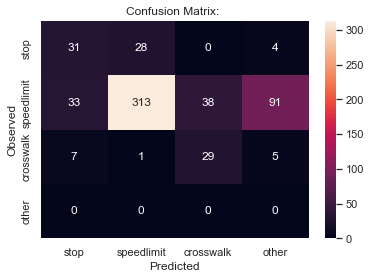

In [13]:
actual = sheet['B']
detected = sheet['C']

def mapping(cell):
    return cell.value

actual = list(map(mapping, actual[1:]))
detected = list(map(mapping, detected[1:]))


def roc_auc_score_multiclass(actual_class, detected_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in detected_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict
    
def evaluation(actual, detected):
    report = classification_report(
        actual, detected, output_dict=True, zero_division=0)
    print(f"Report:\n{classification_report(actual, detected,zero_division= 0)}\n")
    print(f"AUC Score:\n{roc_auc_score_multiclass(actual, detected)}\n")
    sb.set(font_scale=1.0)
    labels = ["stop", "speedlimit", "crosswalk","other"]
    i = 0
    cm = confusion_matrix(actual, detected, labels=["stop", "speedlimit", "crosswalk","other"])
    ax = plt.subplot()
    sb.heatmap(cm, annot=True, ax=ax, fmt="g")

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Observed')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    ax.set_title("Confusion Matrix: ")
    plt.show()
    i += 1

evaluation(actual, detected)


# Possible Improvements - 15% of the grade

## Multiple Sign Detection Example - Same Type of Sign Example

In [14]:
originalImg = cv2.imread(os.path.join(improvementsImagesDir, "41nzeb1v-900.jpg"))

(nrStops, imageForPrint) = detectStops(originalImg, True,originalImg)

cv2.imshow('Stops Detected', imageForPrint)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Multiple Sign Detection Example - Different Type of Sign Example

In [15]:
originalImg = cv2.imread(os.path.join(dataDir, "road517.png"))

imageForPrint = originalImg.copy()

(nrCircles, imageForPrint) = detectCircles(originalImg, True, imageForPrint, "red")

(nrSquares, imageForPrint) = detectBlueSquaredRectangles(originalImg, True,imageForPrint)

cv2.imshow('Stops Detected', imageForPrint)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Function to Detect Blue Circles - Example

In [16]:
ogImg = cv2.imread(os.path.join(improvementsImagesDir, "blueCircleRedTriangle.jpg"))   
    
(nrCircles, ogImg) = detectCircles(ogImg, True, ogImg.copy(), "blue")

cv2.imshow('Blue Circles Detected', ogImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Function to Detect Triangular Signs - Example

In [17]:
originalImg = cv2.imread(os.path.join(improvementsImagesDir, "blueCircleRedTriangle.jpg"))

(nrTriangles, newImage) = detectTriangles(originalImg, True, originalImg)

cv2.imshow('Triangles Detected', newImage)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Detecting Red Circle With Shadows

In [18]:
ogImg = cv2.imread(os.path.join(improvementsImagesDir, "road337.png"))   
    
(nrCircles, ogImg) = detectCircles(ogImg, True, ogImg, "red")

cv2.imshow('Red Circles Detected', ogImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Detecting Stop Sign in Poorly Illuminated Image

In [19]:
originalImg = cv2.imread(os.path.join(improvementsImagesDir, "road73.png"))

(nrStops, newImage) = detectStops(originalImg, True,originalImg)

cv2.imshow('Stop Detected', newImage)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Detecting Red Circle When Not Perpendicular to the Shot
### The circle drawn does not perfectly delimit the sign, however it still identifies it.

In [20]:
ogImg = cv2.imread(os.path.join(improvementsImagesDir, "road106.png"))   
    
(nrCircles, ogImg) = detectCircles(ogImg, True, ogImg, "red")

cv2.imshow('Red Circles Detected', ogImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Detecting Stop Sign When Not Perpendicular to the Shot

In [21]:
originalImg = cv2.imread(os.path.join(improvementsImagesDir, "road70.png"))

(nrStops, newImage) = detectStops(originalImg, True,originalImg)

cv2.imshow('Stop Detected', newImage)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Detecting Blue Rectangular Sign When Not Perpendicular to the Shot

In [22]:
originalImg = cv2.imread(os.path.join(improvementsImagesDir, "road126.png"))

(nrSquares, newImage) = detectBlueSquaredRectangles(originalImg, True, originalImg)

cv2.imshow('Blue Square Detected', newImage)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Detecting Stop Sign With Partial Occlusion

In [23]:
originalImg = cv2.imread(os.path.join(dataDir, "road82.png"))

(nrStops, newImage) = detectStops(originalImg, True, originalImg.copy())

cv2.imshow('Stops Detected', newImage)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Detecting Stop Sign With Over Saturated Image (Sunset)

In [24]:
originalImg = cv2.imread(os.path.join(dataDir, "road86.png"))

(nrStops, newImage) = detectStops(originalImg, True, originalImg.copy())

cv2.imshow('Stops Detected', newImage)
cv2.waitKey(0)
cv2.destroyAllWindows()